<a href="https://colab.research.google.com/github/orlandochr/cervezaatesanal/blob/main/recommending_beers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Análisis de Dataset sobre Reviews de Cervezas para determinar recomendación sobre carácterísticas como Porcentaje de Alcohol, Sabor, Aroma Apareincia etc. 

Proyecto Final Dplomado Machine Learning.

Orlando Chaparro

Recomendación de Cervezas


Notebook Original in https://www.kaggle.com/fabiancpl/recommending-beers 

Dato Original en in: https://www.kaggle.com/rdoume/beerreviews

Metodología y esquema de experimentación badada en: https://www.slideshare.net/tanyacash/strata-2017-nyc-how-to-hire-and-test-for-data-skills-a-onesizefitsall-interview-kit

Importación de librerías

In [1]:
import math
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

# Carga de Datos y analisis de exploratorio de la información

In [3]:
from google.colab import drive
drive.mount('/content/drive/')  

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
beers_df = pd.read_csv('/content/drive/My Drive/beer_review/data/beer_reviews.csv')
 

In [5]:
beers_df.shape

(1586614, 13)

In [6]:
beers_df[ 'review_time' ] = pd.to_datetime( beers_df[ 'review_time' ], unit = 's' )

In [7]:
beers_df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,2009-02-16 20:57:03,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,2009-03-01 13:44:57,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,2009-03-01 14:10:04,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,2009-02-15 19:12:25,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,2010-12-30 18:53:26,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [8]:
beers_df.dtypes

brewery_id                     int64
brewery_name                  object
review_time           datetime64[ns]
review_overall               float64
review_aroma                 float64
review_appearance            float64
review_profilename            object
beer_style                    object
review_palate                float64
review_taste                 float64
beer_name                     object
beer_abv                     float64
beer_beerid                    int64
dtype: object

In [9]:
#pandas_profiling.ProfileReport( beers_df )

In [10]:
# Se considera reviews del 2002 porque los años previos no tienen mucha información.
beers_df = beers_df.loc[ beers_df[ 'review_time' ].dt.year >= 2002 ]

In [11]:
beers_df.shape

(1584276, 13)

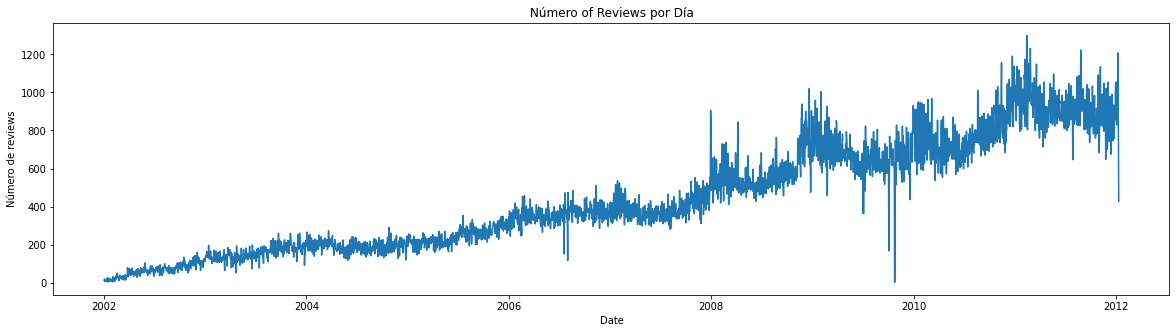

In [12]:
group_by_date = beers_df[ [ 'review_time' ] ].groupby( beers_df[ 'review_time' ].dt.date ).agg( [ 'count' ] )
plt.figure( figsize = ( 20, 5 ) )
plt.plot( group_by_date )
plt.xlabel( 'Date' )
plt.ylabel( 'Número de reviews' )
plt.title( 'Número of Reviews por Día' )
plt.show()

In [13]:
# Canitidad de Cervecerías (breweries) unicas => Problemas de integridad evidenciadas => Id no es considerada para el subscuente analisis
print( 'Cervecerías -breweries- únicas' )
print( 'By id:', beers_df[ 'brewery_id' ].nunique() )
print( 'By name:', beers_df[ 'brewery_name' ].nunique() )

Cervecerías -breweries- únicas
By id: 5835
By name: 5737


In [14]:
# Cantidad unica de cervezas => Integrity issues evidenced => Id is not considered for subsequent analysis
print( 'Cervezas - beers - únicas' )
print( 'By id:', beers_df[ 'beer_beerid' ].nunique() )
print( 'By name:', beers_df[ 'beer_name' ].nunique() )

Cervezas - beers - únicas
By id: 65915
By name: 56748


In [15]:
# Cantidad de usuarios únicos
print( 'Usuarios unicos:', beers_df[ 'review_profilename' ].nunique() )
print( 'Usuarios unicos con mas d 1 review:', beers_df[ 'review_profilename' ].value_counts()[ beers_df[ 'review_profilename' ].value_counts() > 1 ].shape[ 0 ], '-' , str( round( beers_df[ 'review_profilename' ].value_counts()[ beers_df[ 'review_profilename' ].value_counts() > 1 ].shape[ 0 ] / beers_df[ 'review_profilename' ].nunique(), 2 ) * 100 ) + '%' )

Usuarios unicos: 33374
Usuarios unicos con mas d 1 review: 22934 - 69.0%


In [16]:
# Reviews por user
beers_df[ 'review_profilename' ].value_counts().head()

northyorksammy    5817
BuckeyeNation     4661
mikesgroove       4617
Thorpe429         3518
womencantsail     3497
Name: review_profilename, dtype: int64

In [17]:
#  Un subset de Cervezas quitando información de reviews es creada 
grouped_beers_df = beers_df[ [ 'beer_name', 'brewery_name', 'beer_style', 'beer_abv' ] ].drop_duplicates()

In [18]:
# cantidad de cervezas unicas en datset agrupadas =>   Problemas de integridad evidenciadas con respecto al analisis previo => Para id de Cerveza, se usaran ess 4 claves
grouped_beers_df.shape

(65728, 4)

In [19]:
# Cantidad de Cerveza con mismo nombre pero diferente Cervecería. style or AVB% Alcohol by Volumen o % de Alcohol
grouped_beers_df.loc[ grouped_beers_df.duplicated( subset = [ 'beer_name' ], keep = False ) ].sort_values( by = 'beer_name'  ).shape

(11600, 4)

In [20]:
# Cervezas por Cervecería (Brewery)
grouped_beers_df[ 'brewery_name' ].value_counts( dropna = False ).head()

Rock Bottom Restaurant & Brewery      875
John Harvard's Brewery & Ale House    390
Goose Island Beer Co.                 368
Iron Hill Brewery & Restaurant        316
Minneapolis Town Hall Brewery         312
Name: brewery_name, dtype: int64

In [21]:
# Cervveza por Estilo - Beers by style
grouped_beers_df[ 'beer_style' ].value_counts( dropna = False ).head()

American IPA                3592
American Pale Ale (APA)     3311
American Amber / Red Ale    2496
American Porter             2180
Fruit / Vegetable Beer      1826
Name: beer_style, dtype: int64

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


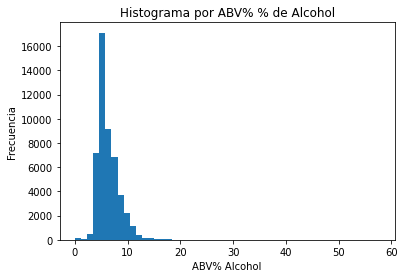

In [22]:
plt.figure()
plt.hist( grouped_beers_df[ 'beer_abv' ], bins = 50 )
plt.xlabel( 'ABV% Alcohol' )
plt.ylabel( 'Frecuencia' )
plt.title( 'Histograma por ABV% % de Alcohol' )
#plt.yscale( 'log' )
plt.show()

Text(0.5, 1.0, 'Pearson Correlation')

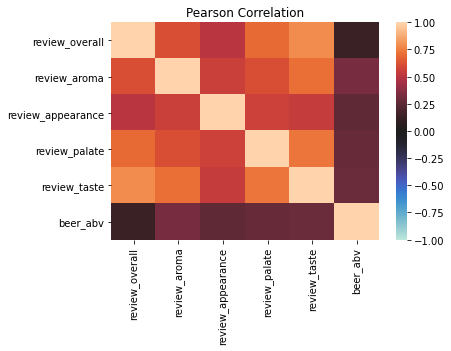

In [23]:
# Diagrama de correlación de Pearson - Pearson correlation
sns.heatmap( beers_df[ [ 'review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'beer_abv' ] ].corr(), center = 0,  vmin = -1, vmax = 1 )
plt.title( 'Pearson Correlation' )

Text(0.5, 1.0, 'Spearman Correlation')

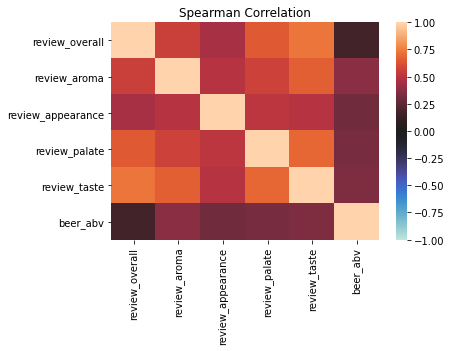

In [24]:
# Diagrama de correlación de Spearman - Spearman correlation
sns.heatmap( beers_df[ [ 'review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'beer_abv' ] ].corr( method = 'spearman' ), center = 0,  vmin = -1, vmax = 1 )
plt.title( 'Spearman Correlation' )

In [25]:
# Se crea una nueva medida promediando la revisión por factor - An new meassure is created by averaging review by factor
beers_df[ 'review_average' ] = round( ( ( beers_df[ 'review_overall' ] + beers_df[ 'review_aroma' ] + beers_df[ 'review_appearance' ] + beers_df[ 'review_palate' ] + beers_df[ 'review_taste' ] ) / 5 ) * 2 ) / 2

In [26]:
# Agrupación por diferentes factores de revisión para fines de visualización - Groupping by different review factors for visualization purposes
group_by_review_overall = beers_df[ 'review_overall' ].value_counts( dropna = False ).reset_index().rename( columns = { 'index' : 'review', 'review_overall' : 'overall' } ).sort_values( by = 'review' )
group_by_review_aroma = beers_df[ 'review_aroma' ].value_counts( dropna = False ).reset_index().rename( columns = { 'index' : 'review', 'review_aroma' : 'aroma' } ).sort_values( by = 'review' )
group_by_review_appearance = beers_df[ 'review_appearance' ].value_counts( dropna = False ).reset_index().rename( columns = { 'index' : 'review', 'review_appearance' : 'appearance' } ).sort_values( by = 'review' )
group_by_review_palate = beers_df[ 'review_palate' ].value_counts( dropna = False ).reset_index().rename( columns = { 'index' : 'review', 'review_palate' : 'palate' } ).sort_values( by = 'review' )
group_by_review_taste = beers_df[ 'review_taste' ].value_counts( dropna = False ).reset_index().rename( columns = { 'index' : 'review', 'review_taste' : 'taste' } ).sort_values( by = 'review' )
group_by_review_average = beers_df[ 'review_average' ].value_counts( dropna = False ).reset_index().rename( columns = { 'index' : 'review', 'review_average' : 'average' } ).sort_values( by = 'review' )

group_by_review_overall[ 'review' ] = group_by_review_overall[ 'review' ].astype( str )
group_by_review_aroma[ 'review' ] = group_by_review_aroma[ 'review' ].astype( str )
group_by_review_appearance[ 'review' ] = group_by_review_appearance[ 'review' ].astype( str )
group_by_review_palate[ 'review' ] = group_by_review_palate[ 'review' ].astype( str )
group_by_review_taste[ 'review' ] = group_by_review_taste[ 'review' ].astype( str )
group_by_review_average[ 'review' ] = group_by_review_average[ 'review' ].astype( str )

group_by_review = group_by_review_overall.merge( group_by_review_aroma, how = 'outer', on = [ 'review' ] )
group_by_review = group_by_review.merge( group_by_review_appearance, how = 'outer', on = [ 'review' ] )
group_by_review = group_by_review.merge( group_by_review_palate, how = 'outer', on = [ 'review' ] )
group_by_review = group_by_review.merge( group_by_review_taste, how = 'outer', on = [ 'review' ] )
group_by_review = group_by_review.merge( group_by_review_average, how = 'outer', on = [ 'review' ] )
group_by_review = group_by_review.fillna( 0 )

Text(0.5, 0.98, 'Distribution of Reviews by Value')

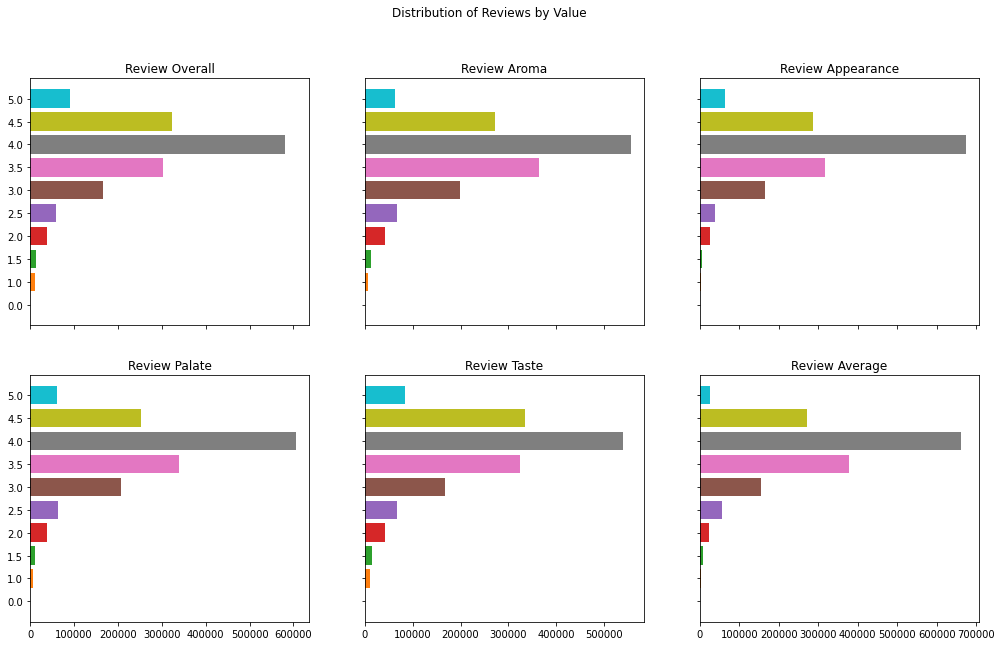

In [27]:
cm = plt.cm.get_cmap( 'tab10' ).colors
f, ( ( ax1, ax2, ax3 ), ( ax4, ax5, ax6 ) ) = plt.subplots( 2, 3, sharex = 'col', sharey = 'row', figsize = ( 17, 10 ) )
ax1.barh( group_by_review[ 'review' ], group_by_review[ 'overall' ], color = cm )
ax1.set_title( 'Review Overall' )
ax2.barh( group_by_review[ 'review' ], group_by_review[ 'aroma' ], color = cm )
ax2.set_title( 'Review Aroma' )
ax3.barh( group_by_review[ 'review' ], group_by_review[ 'appearance' ], color = cm )
ax3.set_title( 'Review Appearance' )
ax4.barh( group_by_review[ 'review' ], group_by_review[ 'palate' ], color = cm )
ax4.set_title( 'Review Palate' )
ax5.barh( group_by_review[ 'review' ], group_by_review[ 'taste' ], color = cm )
ax5.set_title( 'Review Taste' )
ax6.barh( group_by_review[ 'review' ], group_by_review[ 'average' ], color = cm )
ax6.set_title( 'Review Average' )
f.suptitle( 'Distribution of Reviews by Value' )

# Aggregating reviews

In [28]:
# This is a python implementarion of the Lower bound of Wilson score confidence interval for a Bernoulli parameter
# Implementation details: http://www.evanmiller.org/how-not-to-sort-by-average-rating.html?fbclid=IwAR2RNIB8geL9V0V9ereqidgRMasdytDOoqlGfCKWOcrRHKsUHFzMb7Xkemw

# pos: number of positive ratings
# n: total number of ratings
def ci_lower_bound( pos, n ):
    if n == 0:
        return 0
    z = 1.96 # For a IC of 0.95
    phat = 1.0 * pos / n
    return ( phat + ( z ** 2 ) / ( 2 * n ) - z * math.sqrt( ( phat * ( 1 - phat ) + ( z ** 2 ) / ( 4 * n ) ) / n ) ) / ( 1 + ( z ** 2 ) / n )

In [29]:
# Aggregation function for reviews
# Positive reviews are defined as a constant fraction of their real value
# Aggregation is performed using the Lower bound of Wilson score confidence interval for a Bernoulli parameter
def agg_reviews( reviews ):
    pos = 0
    for index, review in reviews[ reviews >= 3 ].iteritems():
        pos += review / 5
    #pos = ratings[ ratings >= 3 ].shape[ 0 ]
    return ci_lower_bound( pos, reviews.shape[ 0 ] ) * 5

In [30]:
# Grouping beers and aggregating reviews
grouped_beers_df = beers_df.groupby( [ 'beer_name', 'brewery_name', 'beer_style', 'beer_abv' ] ) \
    .agg( { 'review_overall' : agg_reviews, 'review_aroma' : agg_reviews, 'review_appearance' : agg_reviews, 'review_palate' : agg_reviews, 'review_taste' : agg_reviews, 'review_average' : agg_reviews, 'review_profilename' : 'count' } ).reset_index() \
    .rename( columns = { 'review_profilename' : 'number_of_reviews' } )

In [31]:
# Cantidad de cervezas unicas - Count of unique beers
grouped_beers_df[ 'beer_name' ].nunique()

44061

In [32]:
# TOP 5 de Cervezas por numero de reviews - TOP 5 beers by number of reviews
grouped_beers_df.sort_values( by = 'number_of_reviews', ascending = False ).head()

,beer_name,brewery_name,beer_style,beer_abv,review_overall,review_aroma,review_appearance,review_palate,review_taste,review_average,number_of_reviews
731,90 Minute IPA,Dogfish Head Brewery,American Double / Imperial IPA,9.0,4.020191,4.131679,4.121969,4.087696,4.223766,4.133715,3288
31841,Old Rasputin Russian Imperial Stout,North Coast Brewing Co.,Russian Imperial Stout,9.0,4.064484,4.116345,4.311672,4.145139,4.254089,4.188800,3097
39557,Sierra Nevada Celebration Ale,Sierra Nevada Brewing Co.,American IPA,6.8,4.054146,3.988222,4.150608,3.974983,4.080001,4.046394,2986
45123,Two Hearted Ale,"Bell's Brewery, Inc.",American IPA,7.0,4.240870,4.186700,4.071694,4.046744,4.234592,4.168100,2726
41835,Stone Ruination IPA,Stone Brewing Co.,American Double / Imperial IPA,7.7,4.040809,4.264611,4.099740,4.099167,4.257311,4.165487,2702


#  Que Cervecería produce la Cerveza más fuerte por % de Alcohol - ABV%?

In [33]:
# Cerveza con % de Alcohol (ABV% )mayor a 30 
grouped_beers_df.loc[ grouped_beers_df[ 'beer_abv' ] > 30 ] \
    .sort_values( by = [ 'beer_abv' ], ascending = False )[ [ 'brewery_name', 'beer_name', 'beer_abv' ] ]

,brewery_name,beer_name,beer_abv
38654,Schorschbräu,Schorschbräu Schorschbock 57%,57.70
38653,Schorschbräu,Schorschbräu Schorschbock 43%,43.00
39782,BrewDog,Sink The Bismarck!,41.00
38652,Schorschbräu,Schorschbräu Schorschbock 40%,39.44
5796,De Struise Brouwers,Black Damnation VI - Messy,39.00
42915,BrewDog,Tactical Nuclear Penguin,32.00
38651,Schorschbräu,Schorschbräu Schorschbock 31%,30.86


Schorschbräu es la Cervecería que produce la cerveza con porcentaje más alto de alcohol (ABV%), seguido de BrewDog y De Struise Brouwers.

# Si tuvieras que elegir 3 cervezas para recomendar basado solo en estos datos, ¿cuál elegirías?

Las reseñas después de la agrupación están en función de las reseñas individuales de cada usuario y del número de reseñas de esa cerveza. Las cervezas con muchas calificaciones individuales altas probablemente tendrán una calificación agrupada alta.



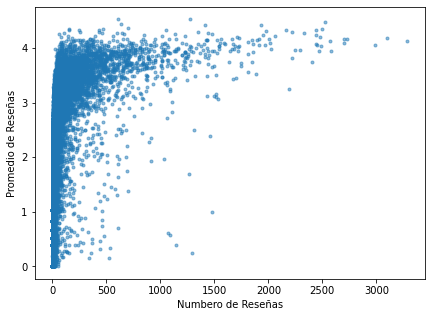

In [34]:
plt.figure( figsize = ( 7, 5 ) )
plt.scatter( grouped_beers_df[ 'number_of_reviews' ], grouped_beers_df[ 'review_average' ], marker ='.', alpha = .5 )
plt.xlabel( 'Numbero de Reseñas' )
plt.ylabel( 'Promedio de Reseñas' )
plt.show()

In [35]:
grouped_beers_df.sort_values( by = 'review_average', ascending = False ).head( 3 )

,beer_name,brewery_name,beer_style,beer_abv,review_overall,review_aroma,review_appearance,review_palate,review_taste,review_average,number_of_reviews
44523,Trappist Westvleteren 12,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,Quadrupel (Quad),10.2,4.530716,4.495034,4.354817,4.539659,4.646554,4.524758,1272
34257,Pliny The Younger,Russian River Brewing Company,American Double / Imperial IPA,11.0,4.474180,4.618422,4.349282,4.492465,4.615607,4.523674,610
34256,Pliny The Elder,Russian River Brewing Company,American Double / Imperial IPA,8.0,4.525157,4.555939,4.317931,4.380363,4.569367,4.478398,2527


Estas son las 3 cervezas con mayor promedio de reseñas. Como era de esperar, estas cervezas también cuentan con un importante número de reseñas

# ¿Cuáles de los factores (aroma, sabor, apariencia, paladar) son más importantes para determinar la calidad general de una cerveza?

En términos de correlación (pearson o spearman), la clasificación parece ser: sabor, paladar, aroma y apariencia. 

Una perspectiva más sofisticada puede ser entrenar un modelo de regresión lineal.

In [36]:
# Defining the linear model
linear_model = LinearRegression( normalize = True )

In [37]:
#  Entrenamiento y generación de predicciones para el modelo
linear_model.fit( X = beers_df[ [ 'review_aroma', 'review_appearance', 'review_palate', 'review_taste' ] ], y = beers_df[ 'review_overall' ] )
preds = linear_model.predict( beers_df[ [ 'review_aroma', 'review_appearance', 'review_palate', 'review_taste' ] ] )

In [38]:
# Coeficientes para cada característica (aroma, apariencia, paladar, gusto)
linear_model.coef_

array([0.04775205, 0.03561118, 0.25846474, 0.55172152])

In [39]:
# Validando el error en el modelo
# Aparentemente, un modelo lineal es suficiente para representar el fenómeno evidenciando un error global de 0.42 cuando el rango de valores posibles para el objetivo está entre 0 y 5
# Deben desarrollarse los esquemas de validación más sofisticados
np.sqrt( mean_squared_error( beers_df[ 'review_overall' ], preds ) )

0.42136593232122704

De manera similar a los resultados por correlación, los coeficientes que aportan más información al modelo son los correspondientes a características gustativas y aromáticas.

# Si normalmente disfruto de una cerveza debido a su aroma y apariencia, ¿qué estilo de cerveza debo probar?

Estos son los estilos de cerveza para el top 10 de cervezas con más reseñas de aroma y apariencia.

In [40]:
grouped_beers_df.sort_values( by = [ 'review_aroma', 'review_appearance' ], ascending = False ).head( 10 ) \
    [ 'beer_style' ].unique().tolist()

['American Double / Imperial IPA',
 'American Double / Imperial Stout',
 'Quadrupel (Quad)',
 'Russian Imperial Stout']

In [ ]:
# Para exportar en html esta notebook
# %%shell
# upyter nbconvert --to html /content/recommending_beers.ipynb